In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import json
import plotly.express as px
import pandas as pd
import numpy as np

## 1. Load nodes and edges from JSON file

In [2]:
nodes = json.load(open('./genshin_data/node_list.json', 'rb'))
edges = json.load(open('./genshin_data/edge_list.json', 'rb'))

In [3]:
 # example look of the node_list JSON file
nodes[1]

{'id': 'Keqing', 'nation': 'Liyue'}

In [4]:
# example look of the edge_list JSON file
edges[1]

{'type': 'voice', 'from': 'Amber', 'to': 'Klee'}

In [5]:
%%time

# create directed graph
directed_graph = nx.DiGraph()

# add characters with a nation attribute
for node in nodes:
    directed_graph.add_node(node['id'], nation=node['nation'])

# add character relations
for edge in edges:
    directed_graph.add_edge(edge['from'], edge['to'], type=edge['type'])

Wall time: 1e+03 µs


In [6]:
# basic node and edge stats from networkx
print("Number of nodes:", directed_graph.number_of_nodes())
print("Number of edges:", directed_graph.number_of_edges())

Number of nodes: 35
Number of edges: 262


### In the Genshin Impact character network, we have 35 character nodes and 262 connections.

In [42]:
# setting node colours for drawing
nation_color_dict = {
    'Mondstadt': '#aff8db',
    'Liyue': '#ffcbc1',
    'Inazuma': '#d5aaff',
    'Snezhnaya': '#ace7ff'
}

# for each node, assign the node a color based on the
# the color map dictionary if the nation is existed in 
# the color map dictionary
node_colors = []
for node, nation in list(directed_graph.nodes(data="nation")):
    if nation in nation_color_dict:
        node_colors.append(nation_color_dict[nation])
    else:
        node_colors.append('#FFA500') # traveler doesn't belong to any nation

In [51]:
def plot_genshin_network(graph, node_colors, legend_tiles,
                         title="Genshin Impact Character Social Network"):
    # create spring layout for 25 iterations to separate the nodes
    np.random.seed(2021)
    pos = nx.spring_layout(graph, k=0.3, iterations=25)

    plt.figure(1,figsize=(15,15)) 
    nx.draw(graph,
            pos = pos,
            node_size=2000,
            node_color=node_colors,
            with_labels=True,
            font_size = 11,
            font_color='black')

    plt.title(title)
    plt.legend(handles=legend_tiles, loc="upper left")
    plt.show()

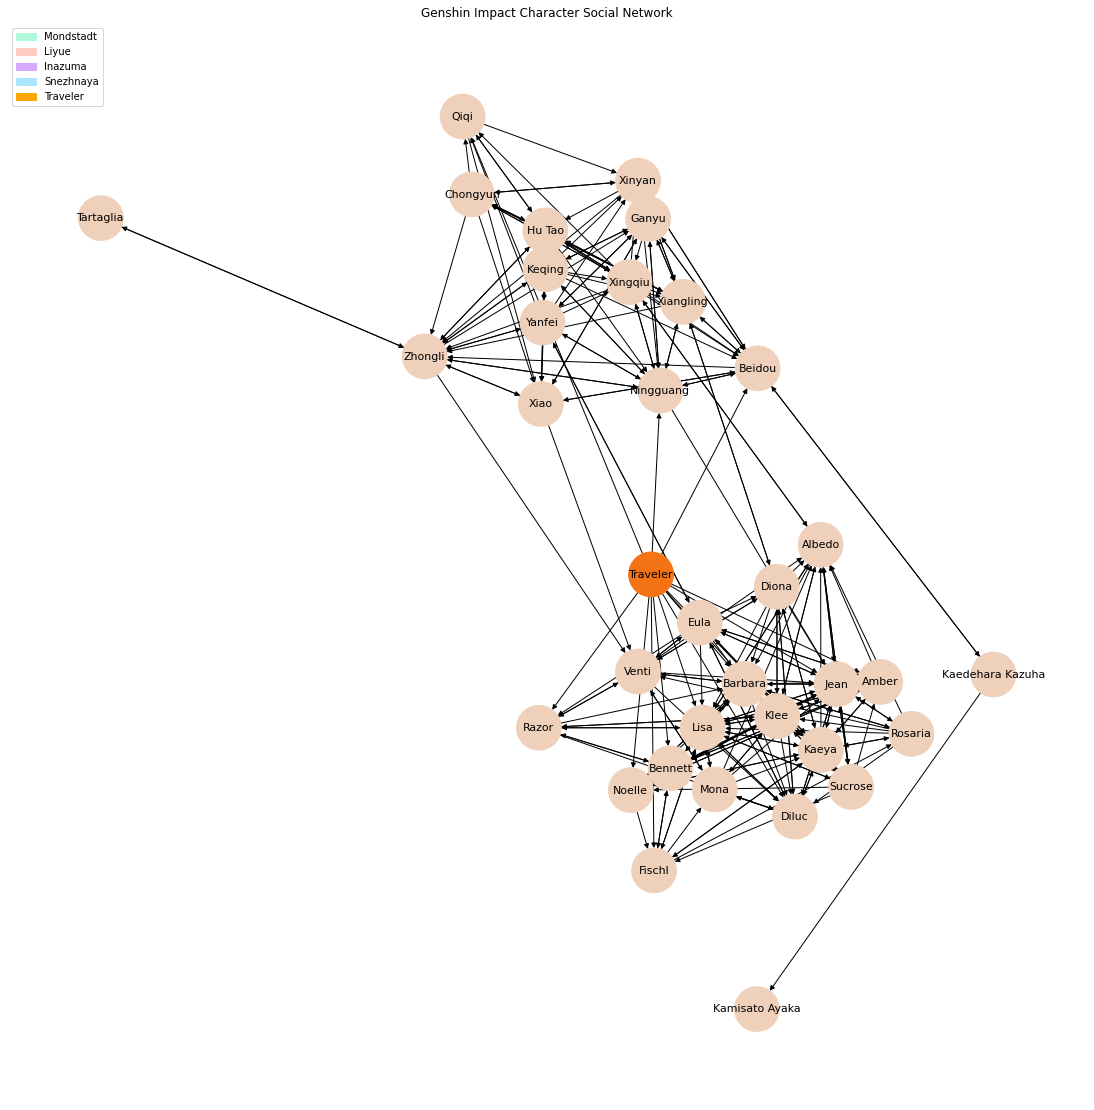

Wall time: 2.05 s


In [52]:
%%time

legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya"),
                mpatches.Patch(color="#FFA500", label="Traveler"),
               ]
plot_genshin_network(directed_graph, node_colors, legend_tiles,
                     title="Genshin Impact Character Social Network")
# uncomment to save picture
# plt.savefig('directed.png')

## Description Statistics:

## 2. Centrality / Node Importance
What characterizes an important node?

### 2.1 Degree centrality (local importance)

1. Assumption: important nodes have many connections.
2. Definition: measure node n’s importance by the degree of node n over total number of nodes
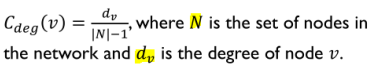
3. Interpretation: which node is the most important one with the most number of connections/friends/followers?

### Since the graph is directed, we will have in-degree and out-degree centrality.

In [18]:
in_degree_centrality_df = pd.DataFrame(nx.in_degree_centrality(directed_graph).items(), 
                                       columns=["node", "in_degree_centrality"])
in_degree_centrality_df.sort_values("in_degree_centrality", ascending=False).head(10)

,node,in_degree_centrality
34,Jean,0.500000
24,Lisa,0.441176
5,Kaeya,0.382353
6,Klee,0.382353
10,Diluc,0.352941
19,Barbara,0.323529
4,Zhongli,0.323529
16,Albedo,0.323529
15,Beidou,0.294118
12,Ningguang,0.294118


### Jean has the highest in-degree centrality. This implies Jean is mostly mentioned by other character in their storyline and voice memo.

In [46]:
# for a given graph and an important node,
# return suitable node color list for visualization
def get_centrality_node_colors(graph, important_node):
    node_colors = ["#EFD1BB"] * len(graph.nodes())
    node_colors[list(graph.nodes()).index(important_node)] = "#F47315"
    return node_colors

In [57]:
# %%time
# legend_tiles = [mpatches.Patch(color="#EFD1BB", label="Others"),
#                 mpatches.Patch(color="#F47315", label="Most Important Node")
#                ]
# node_colors = get_centrality_node_colors(directed_graph, "Jean")
# plot_genshin_network(directed_graph, node_colors, legend_tiles,
#                      title="In-Degree Centrality Visualization")

In [19]:
out_degree_centrality_df = pd.DataFrame(nx.out_degree_centrality(directed_graph).items(), 
                                       columns=["node", "out_degree_centrality"])
out_degree_centrality_df.sort_values("out_degree_centrality", ascending=False).head(10)

,node,out_degree_centrality
25,Traveler,0.411765
24,Lisa,0.352941
34,Jean,0.323529
5,Kaeya,0.323529
6,Klee,0.323529
14,Eula,0.323529
1,Keqing,0.264706
29,Diona,0.264706
8,Yanfei,0.264706
22,Hu Tao,0.264706


### If we look at out-degree centrality, Traveler is the most important character to connect to the rest of the intermediate characters. It makes sence because Traveler is the main character visiting different regions to connect the storylines. 

In [56]:
# %%time

# legend_tiles = [mpatches.Patch(color="#EFD1BB", label="Others"),
#                 mpatches.Patch(color="#F47315", label="Most Important Node")
#                ]
# node_colors = get_centrality_node_colors(directed_graph, "Traveler")
# plot_genshin_network(directed_graph, node_colors, legend_tiles,
#                      title="Out-Degree Centrality Visualization")

### 2.2 Closeness centrality (path spread importance)

1. Assumption: important nodes are close to other nodes
2. Definition: normalize the total shortest path lengths between the node n and all other nodes in the graph by the N-1 number of nodes in the network.
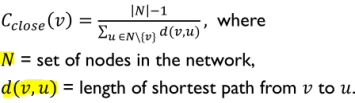
3. Interpretation: 
    * smaller total shortest path lengths of a node n to all other nodes will result in larger centrality value; hence, the closer it is to all other nodes, the more central a node is.
    * In social networks, we wanted to spread an innovation or a new product among the actors in the fastest amount of time, we would want to give it to the node with the highest closeness centrality first.

In [60]:
closeness_centrality_df = pd.DataFrame(nx.closeness_centrality(directed_graph).items(), 
                                       columns=["node", "closeness_centrality"])
closeness_centrality_df.sort_values("closeness_centrality", ascending=False).head(10)

,node,closeness_centrality
34,Jean,0.604329
28,Venti,0.542871
16,Albedo,0.525072
29,Diona,0.508403
24,Lisa,0.492760
19,Barbara,0.492760
10,Diluc,0.492760
13,Xingqiu,0.478051
5,Kaeya,0.471021
6,Klee,0.471021


### Based on the closeness centrality results, Jean is also the the most important character with closeness centrality of 0.604. It implies that Jean is closer to all the other nodes with relative shorter shorest path lengths connecting all the other character. If the characters want to find someone to help spread the news in the fastest amount of time, Jean would be a good person to do.

### 2.3 Betweenness centrality (In-between/broker/bridge/middleman importance)

1. Assumption: : important nodes will be the broker on the way to connect two other nodes without being directly connected to every node.

2. Definition: quantifies the sum of (the number of times a node acts as a bridge/middleman along the shortest path between two other nodes) / (the total number of existing shortest paths between two other nodes)
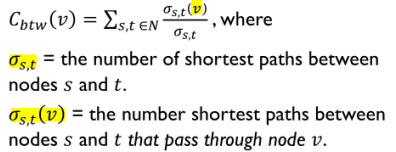

3. Interpretation: 
    * Higher sum of fractions means more shortest paths between any two nodes in the
network will have the node n involved, which implies higher importance as a bridge or
a broker in the network.
    * When interpreting normalized betweenness centrality, the number stands for how
many percent of the shortest paths between pairs of nodes in the graph will pass
through a given node n.
    * The node with higher betweenness centrality is able to pass messages from a node a
to another node b by traversing relatively small distances.


In [64]:
betweenness_centrality_df = pd.DataFrame(nx.betweenness_centrality(directed_graph).items(), 
                                       columns=["node", "betweenness_centrality"])
betweenness_centrality_df.sort_values("betweenness_centrality", ascending=False).head(10)

,node,betweenness_centrality
16,Albedo,0.134878
13,Xingqiu,0.132108
34,Jean,0.096456
15,Beidou,0.094075
4,Zhongli,0.092939
28,Venti,0.092471
29,Diona,0.085169
14,Eula,0.084201
3,Xiangling,0.081891
8,Yanfei,0.069288


### Measuring the importance of node being the broker to connect the paths between any two other nodes, Albedo is the most import node with betweenness_centrality of 0.135. This implies that 13.5% of the shortest paths between any pair of nodes in the graph will pass through Albedo.

### Edge betweenness centrality: 

### We can apply the same framework to find an important edge that has node s and node t pass through the edge instead of a node.
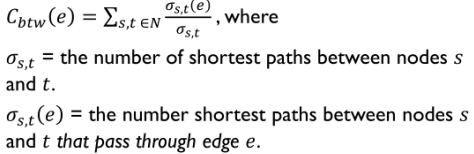

In [66]:
edge_betweenness_centrality_df = pd.DataFrame(nx.edge_betweenness_centrality(directed_graph).items(), 
                                       columns=["edge", "betweenness_centrality"])
edge_betweenness_centrality_df.sort_values("betweenness_centrality", ascending=False).head(10)

,edge,betweenness_centrality
127,"(Albedo, Xingqiu)",0.118807
108,"(Eula, Yanfei)",0.063184
96,"(Ningguang, Jean)",0.060183
223,"(Diona, Xiangling)",0.060026
117,"(Beidou, Kaedehara Kazuha)",0.055462
37,"(Zhongli, Venti)",0.043013
211,"(Xiao, Venti)",0.038645
28,"(Xiangling, Diona)",0.036625
104,"(Xingqiu, Beidou)",0.036291
180,"(Kaedehara Kazuha, Kamisato Ayaka)",0.028571


### Measuring the importance of edge being the bridge to connect the shortest paths between any two other nodes, the edge of `Albedo->Xingqiu` is the most import edge with betweenness_centrality of 0.119. This implies that 11.9% of the shortest paths between any pair of nodes in the graph will pass through this edge.